In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')
seed = 27

# Loading Data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')

test_ids = test['id']

In [3]:
train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


# Preprocessing

In [4]:
train['Sex'] = train['Sex'].map({'M': 0, 'F': 1, 'I': 2})
test['Sex'] = test['Sex'].map({'M': 0, 'F': 1, 'I': 2})

features_to_scale = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']

scaler = StandardScaler()
train[features_to_scale] = scaler.fit_transform(train[features_to_scale])
test[features_to_scale] = scaler.transform(test[features_to_scale])

In [5]:
X = train.drop(['id', 'Rings'], axis=1)
y = train['Rings']

X_test = test.drop('id', axis=1)

# Defining CV & Training Function

In [6]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def cv_rmse(model):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    rmse = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse.append(rmsle(y_val, y_pred))
    return np.mean(rmse)

# Training Base Models

In [7]:
models = [
    CatBoostRegressor(random_state=seed, verbose=False),
    LGBMRegressor(random_state=seed, verbose=-1),
    DecisionTreeRegressor(random_state=seed),
    RandomForestRegressor(random_state=seed, n_jobs=-1),
    GradientBoostingRegressor(random_state=seed),
    KNeighborsRegressor(n_jobs=-1),
    XGBRegressor(random_state=seed, n_jobs=-1),
]

In [8]:
model_scores = {}
for model in models:
    score = cv_rmse(model)
    model_scores[model.__class__.__name__] = score
    print(f'{model.__class__.__name__}: {score}')

CatBoostRegressor: 0.14945001834160285
LGBMRegressor: 0.15043815177506134
DecisionTreeRegressor: 0.21595612753815946
RandomForestRegressor: 0.15408457977045256
GradientBoostingRegressor: 0.1530352367914934
KNeighborsRegressor: 0.16540187814778026
XGBRegressor: 0.1511116786232252


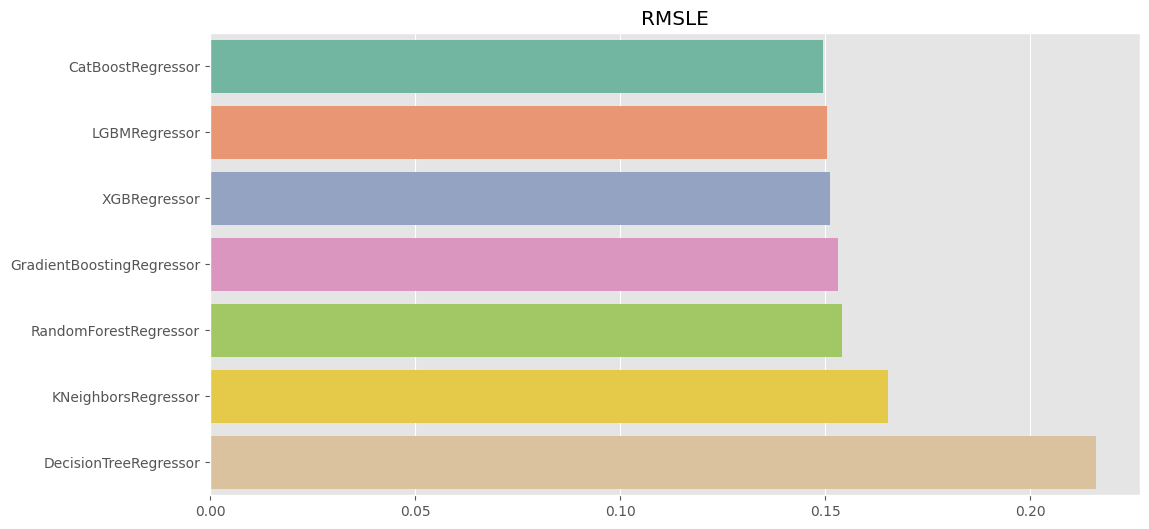

In [9]:
model_scores = dict(sorted(model_scores.items(), key=lambda x: x[1]))

plt.figure(figsize=(12, 6))
sns.barplot(y=list(model_scores.keys()), x=list(model_scores.values()), palette="Set2")
plt.title('RMSLE')
plt.show()

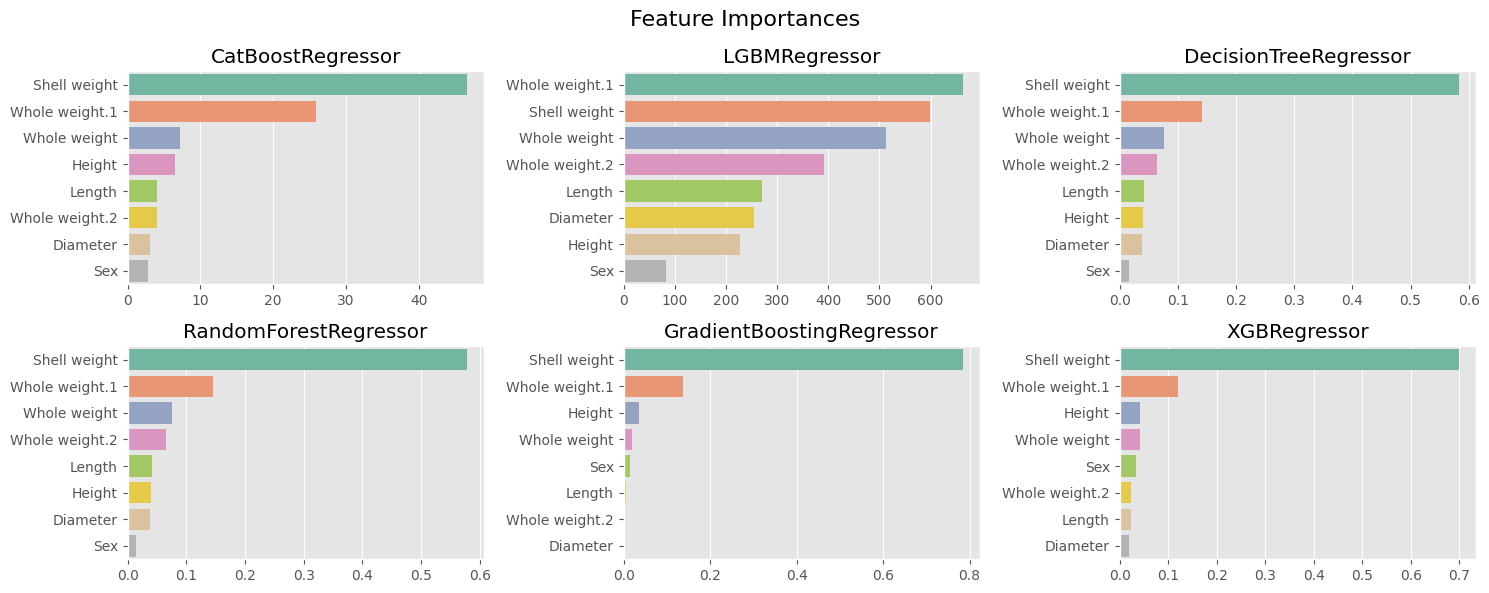

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6))
fig.suptitle('Feature Importances', fontsize=16)

model_index = 0
for model in models:
    if hasattr(model, 'feature_importances_'):
        ax = axs[model_index // 3, model_index % 3]
        feature_importances = pd.Series(model.feature_importances_, index=X.columns)
        feature_importances_sorted = feature_importances.sort_values(ascending=False)
        sns.barplot(y=feature_importances_sorted.index, x=feature_importances_sorted.values, palette="Set2", ax=ax)
        ax.set_title(model.__class__.__name__)
        ax.set_ylabel('')
        model_index += 1

plt.tight_layout()
plt.show() 

# Training the Best Model and Creating a Submission File

In [11]:
best_model = list(model_scores.keys())[0]
model = [model for model in models if model.__class__.__name__ == best_model][0]

model.fit(X, y)
predictions = model.predict(X_test)

In [12]:
submission = pd.DataFrame({'id': test_ids, 'Rings': predictions})
submission.to_csv(f'{best_model}.csv', index=False)
submission.head()

,id,Rings
0,90615,9.590058
1,90616,9.696994
2,90617,10.236317
3,90618,10.082051
4,90619,7.553735
